# Importing the Libraries and Data

In [380]:
import pandas
import numpy as np
import matplotlib.pyplot as plt
df = pandas.read_csv('S&P5yrSample.csv', usecols = ['Open'])
print(df)

             Open
0     2015.290039
1     2023.329956
2     2032.359985
3     2032.010010
4     2038.199951
...           ...
1252  3032.120117
1253  3035.389893
1254  3039.739990
1255  3046.899902
1256  3050.719971

[1257 rows x 1 columns]


# Defining the Variables

In [381]:
j_loops = 1000              # The number of data points we want to include and subsequently, the number of loops. j_loops will be the length of the array "events"
m = 8                      # m controls the time window of which the average is taken and compared to a chosen value. Currentlly set to 8 for 1 week chunks.
indices = [0,1,2,3,4,5,6]  # An array that contains the desired incides in array A, so that a mean can be taken.
event_threshold = 1.03     # The threshold for extreme price jumps. This determines how sensitive the model is in detecting an event.
beta = 0.01                 # The decay constant for the exponential kernel. This will need to be fitted to match the data.

# Detecting Events in the Financial Data

Creating an array called "events" containing 1's (events) and 0's (non-events).

A variable "j" iterates from 1 to "j_loops" which represents how many data points we want to look at. The array, "events", will have a length of "j_loops".

Variable k is set to have a value of j + m. 

j and k define the time window for each "j loops". In this case we are using weekly windows (m = 8).

For a given value of j, array A will be filled with 8 open stock prices. Array B will then use the array "indices" (Defined in the "Variables" section) to take all but the last entry in array A.

A mean of array B is calculated. In this case, the mean is taken from the previous 7 days.

The "chosen_value" is the last entry of array A and is then compared to the mean of array B. The event threshold is used here to determine if the difference between a value and the mean price of the previous week is large enough to class as an event. If this "chosen_value" is outside the boundaries set by "event_threshold", a a value of 1 will be appended to the array "events". Otherwise, a value of 0 will be appended to "events".

Once the for loop is complete, events will contain a series of 1's and 0's indicating the position of events in the time series.

In [382]:
events = []                            # Empty array of events. Outside for loop to be printed afterwards.
for j in range(0,j_loops):             # Iterates between j = 0 and j = the number of times you want it to loop, j_loops.
    A = []                             # Create an empty array A. This will eventually contain a list of open stock prices. 
    k = j + m                          # Set k so that it is always a value of m higher than j.
    for i in range(j,k):               # i will iterate between the values of j and k
        A.append(df.at[i, 'Open'])     # Append the value, located at row i and column 'Open', to the array A
        i+=1              
    j+=1                   

    B = np.take(A, indices)            # Cherry-picks the values that we want from array A.
   
    meanB = np.mean(B)                 # Take the mean of the new array B which is one entry shorter than A
    chosen_value = A[m-1]              # Define the last entry in array A, not contained within array B, as the chosen value.
    
    if chosen_value > event_threshold*meanB:
        events.append(1)
    elif chosen_value < (1/event_threshold)*meanB:
        events.append(1)
    else: 
        events.append(0)

The while loop below, searches for 1's in the array "events" and essentially appends the index (the time) of the event to a new array called "event_times".

In [383]:
t = 0                         
event_times = []              # This array will contain all the event times.
while t < j_loops:            
    if events[t] == 1:        # Searches for events that show up as 1's in the array "events"
        event_times.append(t) # Appends the time of the event to the array "event_times"
    t += 1
print(event_times)      

[21, 22, 26, 35, 193, 194, 195, 196, 218, 223, 225, 226, 287, 288, 289, 290, 292, 309, 315, 406, 810, 811, 812, 814, 843, 844, 983, 984, 985, 993, 994]


Plotting the events as a point process. Each event is represented by a dot.

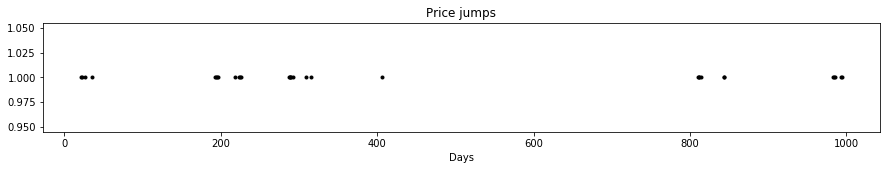

In [384]:
plt.figure(figsize=(15,2))
plt.title("Price jumps")
plt.xlabel("Days")
_ = plt.plot(event_times[:len(event_times)], np.ones(len(event_times)), 'k.') 

# Plotting the Intensity function

I is an array of 0's which is set to a length of j_loops. I is then converted into a numpy array called "total". Numpy arrays allow the corresponding elements of 2 arrays to be added together.

The first for loop, loops for each event contained within the array "event_times".

During each loop, the continuous time t iterates from 0 to the time of the last data point (the length of th array "events"). If the the continuous time (t) is less than the time of an event (T), then a 0 is appended to H. However, once t is greater than or equal to T, the value of the expoential kernel is appended to H. 

This means that the arrival of an event causes the intensity function to jump up by 1, followed by an exponential decay (determined by the decay constant beta which is specified in the "Variables" section.

H is essentially the value of the exponential kernel for a single event. To combine these single events, we use the numpy array "total".

After each loop, the values in H are added to their corresponding elements in "total". This is repeated until "total" is a effectively a superposition of all of the H's. 

The array "total" represents the value of the intensity function over time.

In [385]:
I = [0]*(j_loops)
total = np.array(I)                           # Numpy arrays allow the corresponding elements of 2 arrays to be added together.
for time in range(0,len(event_times)):
    H = []
    T = event_times[time]
    for t in range(0, len(events)):
        if t >= T:                            # This makes sure that the value before an event occurs is zero.
            H.append(np.exp(-beta*(t - T)))
        else:
            H.append(0)  
    h = np.array(H)
    total = total + h
        

Text(0, 0.5, '$\\exp(t-T)$')

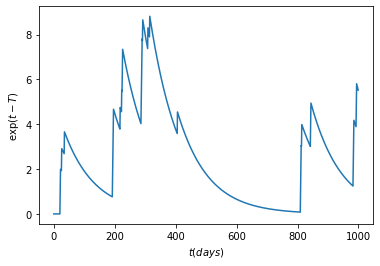

In [386]:
plt.plot(total)
plt.xlabel('$t(days)$')
plt.ylabel('$\exp(t-T)$')

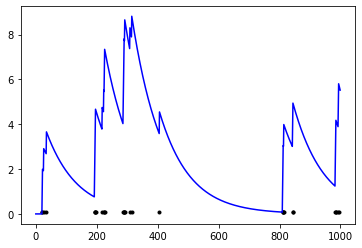

In [387]:
plt.plot(event_times[:len(event_times)], np.ones(len(event_times))* 0.1, 'k.')
_ = plt.plot(np.arange(0, j_loops), total, 'b-')